开篇

一听名字就很觉得意思明白了很多了吧。文档过滤是机器智能应用的一个方面。
主要使用在：

    过滤垃圾邮件
    过滤论坛内垃圾帖子
    博客和维基的垃圾内容

书中提示：本章所讲算法更具有一般性，也就是说不一定只能用来做垃圾过滤，还可以用来完成对邮件分类等等。

早期用于过滤的分类器
早期过滤垃圾的信息非常简单，使用：基于规则的分类器，规则就是人为事先设定好的，比如

    英文字母大写
    与医药品有关的单词
    过于花俏的HTML用色

然而，明显的缺点就是当垃圾邮件的发送者发现了这些规则后，就可以改写垃圾邮件，让过滤器失效。而且，有些词汇客户是真正需要使用，比如医药词汇。又比如一些父母发送邮件的时候不知道怎么关闭大写，所以邮件用大写的方式发送出去了。总之，没有进行个性化的需求制定。比如某些内容对于这个论坛是垃圾内容，但是这些内容对别的论坛却不是。


智能分类器  

我们为了解决这个问题，首先是程序开始的时候收集到足够多的信息，然后根据人们的提示，告诉程序哪些是关键字，哪些不是，不断进行学习。这样我就可以针对不同的用户、群组和网址建立各自的应对策略。  

特征提取   

实际制作一个分类器是要根据不同的情况来从内容抽取特征的，就是可以用来判断内容的具备或者不具备某个特点的东西。比如说如果内容是文档，那么我们一般选择单词作为特征。所以我们要从文档中抽取出单词。我们也相信，作为一个一个的单词，某些单词确实是非常人容易出现在垃圾信息中。当然，如果考虑的更周全，不仅仅是单词，由单词组成的词组或者是短语，都可以用来判断文档是否具有某个特点。
在此，我们做的一个例子恰好就是对文档进行判断。所以我们对需要判断的文档，首先应该将单词一个一个的抽取出来。
代码如下：

In [1]:
import re
import math
'''
import sys   
sys.setrecursionlimit(1000000) 
'''
def getwords(doc):
    splitter = re.compile('\\W*')
    #根据非字母字符进行单词拆分,也就是比如说一句，如果有'号，那么就从那里断开，开始区分单词
    words = [s.lower() for s in splitter.split(doc) if len(s)>2 and len(s) <20]
    
    return dict([w,1] for w in words)

虽然我们用单词来作为文档的特征还是比较合理，但是我有以下问题，依然使得此种方式不太健全。

    单词是否正确被划分了
    标点符号是否也需要作为特征
    是否包含 头信息

此外，为了使得文档能够被正确的划分到相应的类型里面（最简单的情况就是该份文档是否该被划分到垃圾邮件中），我们应该综合实际情况来考虑，比如很多垃圾邮件都是使用的是大写风格，但是我们的getwords函数却把所有函数都转化为了小写。但是作为一个简单的例子，getwords还是足够了。

制作基本分类器   



我们的例子到现在已经选出了特征，如何制作分类器了，很显然分类器就是对我们要求的文档进行分类（你可以理解成对邮件进行分类，再简单点，就是判断就这个邮件是否是垃圾邮件，但这本质上就是进行分类）。作为一个智能的分类器，不再是我们直接告诉这个分类规则了，而是分类进行学习之后，再发挥其分类的功效。专业术语，把分类器进行学习过程称之训练。所谓训练，我们就是传给分类器一个文档，并告诉他这个文档属于什么类型，然后分类器就把这个文档的所有的单词给抽取出来，然后每一个单词多标记一个类型，也就是文档的分类，当有训练了足够多的数据之后。分类器可以用来判断新文档了，判断方式就是将把新文档的单词全部抽取出来，再让这些单词和分类器里面的单词比较，最后看在哪个分类的单词多，那么就把这个篇文档分到哪个类型里面去。

我们将会面向对象的方式来写封装出一个分类器，这样我们可以创建出多个分类器的实例，不同的实例经过不同的学习，就可以满足不同的应用，应对不同的群组的需求。
类的代码如下：

In [8]:

#写一个训练的代码，训练一些样本数据  
def sampletrain(cl):  
    cl.train('Nobody owns the water.','good')  
    cl.train('the quick rabbit jumps fences','good')  
    cl.train('buy pharmaceuticals now','bad')  
    cl.train('make quick money at the online casino','bad')  
    cl.train('the quick brown fox junmps','good')  
class classifier:
    def __init__(self,getfeatures,filename=None):
        #统计特征(例子中的单词)和分类（是否是垃圾邮件）的组合数量  
        self.fc = {}
        ##一个纪录各分类被使用次数的字典,也就是这个分类中有多少多少文档
        self.cc = {}
        #从内容出提取特征，在例子中就是getwords函数  
        self.getfeatures = getfeatures
        
    #对特征和分类变量（self.fc）的改变  
    #f代表feature，本例中的单词，cat是类型  
    def incf(self,f,cat):
        self.fc.setdefault(f,{})
        self.fc[f].setdefault(cat,0)
        self.fc[f][cat] += 1
        
    #增加对某一个分类的计数器
    def incc(self,cat):
        self.cc.setdefault(cat,0)
        self.cc[cat] += 1
        
    #某一特征出现于某一分类中的次数
    def fcount(self,f,cat):
        if f in self.fc and cat in self.fc[f]:
            return float(self.fc[f][cat])
        return 0.0
    
    #属于某一个分类的内容项的数量
    def catcount(self,cat):
        if cat in self.cc:
            return float(self.cc[cat])
        return 0
    #所有内容的数量
    def totalcount(self):
        return sum(self.cc.values())
    #所有分类列表
    def categories(self):
        return self.cc.keys()
    
    def train(self,item,cat):
        features = self.getfeatures(item)
        for f in features:

            #我们就把每一个特征（单词）在响应的特征里面增加一次
            self.incf(f,cat)

        #因为传入了一份文档和分类，然后我们就把这个类型加一次就好。    
        self.incc(cat)
        
    def fprob(self,f,cat):
        if self.catcount(cat) == 0: return 0
         #特征在分类中出现的总次数，除以分类中的包含内容项的总数
        return self.fcount(f,cat)/self.catcount(cat)
    
    def weighteprob(self,f,cat,prf,weight=1.0,ap=0.5):
        #计算当前的概率值，就是计算没有初始假设概率的影响下，只有训练文档的数据产生出来的概率 
        basicprob = prf(f,cat)

        #统计特征在所有分类中出现的总次数
        totals = sum([self.fcount(f,c) for c in self.categories()])

        #计算加权平均  
        bp = ((weight*ap) + (totals*basicprob))/(weight+totals)
        return bp


可以看到，我们对这个类主要有三个变量，fc、cc、features。此外，还有一系列的函数，这些函数非常的适用和常用。
其中fc在本例子中是这个样子的：

特征python单词，被分到good里面6次。
然而，the被分到bad里面3次和good里面3次。

训练函数  


接着训练来看一下训练的函数（属于classifier类）：

In [9]:
def train(self,item,cat):
    features = self.getfeatures(item)
    for f in features:
        
        #我们就把每一个特征（单词）在响应的特征里面增加一次
        self.incf(f,cat)
        
    #因为传入了一份文档和分类，然后我们就把这个类型加一次就好。    
    self.incc(cat)

In [10]:
c1 = classifier(getwords)

In [11]:
c1.train('the quick rabbit jumps fences','good')
c1.train('make quick money at the online casino','bad')


D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


In [12]:
c1.fcount('quick','good')

1.0

In [13]:
c1.fcount('quick','bad')

1.0

我们再执行下面的代码：看看the这个单词的分类情况

In [14]:

cl=classifier(getwords)  
sampletrain(cl)  
print(cl.fcount('the','good'),cl.fcount('the','bad'))  

3.0 1.0


D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


现在我们可以说完成了一个最简单的分类器。然而这根本就不够。继续我们的学习  


贝叶斯分类器
实际概率计算  


我们学习的下一步是：计算一个概率。所谓概率就是0到1之间的数，指某个事件发生的可能性。我要计算的是一个单词出现所在分类的个数占该分类文档的个数的百分比。实际上，我们求是条件概率，通常记作Pr（A|B），就是给定B的条件下的A的概率。我们所求的概率就是Pr（word|classification），就是给定一个分类，某个单词出现的概率。



In [15]:
def fprob(self,f,cat):
    if self.catcount(cat) == 0: return 0
     #特征在分类中出现的总次数，除以分类中的包含内容项的总数
    return self.fcount(f,cat)/self.catcount(cat)

In [16]:
c1 = classifier(getwords)
sampletrain(c1)
c1.fprob('quick','good')

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


0.6666666666666666

我们可以发现一篇“good”分类的文档中包含该单词的概率为，Pr（quick|good）=0.666。这说明了含有good的单词的文档极有可能是没问题的

初始假设概率  

虽然一切现在都很合理，但是还是有一个问题。比如，money由于在赌博相关的文档中出现了一次
cl.train('make quick money at the online casino','bad')
所以，如果我们现在查看Pr（money|good）==0，但是这样是偏激的，因为money是一个中性词，引起这样的现象发生的原因恰好是因为出现了一句money的bad的语句。我们要预防这样的情况，这是因为，我们认为Pr（money|good）不应该只是因为出现在了一个bad的句子，概率就
变成了0。我们想Pr（money|good）的概率逐渐变为0。
解决这个问题的办法就是：设定一个假定的概率，比如Pr（money|good）和Pr（money|bad）初始的概率都为0.5，当然我们并没有偏见，所以单词都一视同仁。接着，当出现这样一个文档时，如下所示：
cl.train('make quick money at the online casino','bad')
我们要在假设概率的基础综合上述文档来做一个计算，算出新的Pr（money|good）和Pr（money|bad）的概率。怎么算，其实很简单，我们赋予假设概率一个权重，这里的例子就算成是和单词的比重一样吧，所以，当出现cl.train('make quick money at the online casino','bad')这个之后，我们可以应该这样计算出新的Pr（money|bad）的概率

(weight*assumedprob+count*fprob)/(count+weight)
=(1*0.5+1*1)/(1+1)
=0.75

这个公式来自于书上，其中count，出现的原因我暂时认为就是因为cl.train('make quick money at the online casino','bad')出现了一次。
等一下需要验证一下（验证结果：其实不是，是单词出现在所有分类中的总次数，不只是在ad或者good，是总次数）。如此，我们现在也能得到Pr（money|good）的概率：0.25。这是理论上的研究，让我们来看一下代码的书写，
下面的代码需要加入到classifier类中：

In [17]:
def weighteprob(self,f,cat,prf,weight=1.0,ap=0.5):
    #计算当前的概率值，就是计算没有初始假设概率的影响下，只有训练文档的数据产生出来的概率 
    basicprob = prf(f,cat)
    
    #统计特征在所有分类中出现的总次数
    totals = sum([self.fcount(f,c) for c in self.categories()])
    
    #计算加权平均  
    bp = ((weight*ap) + (totals*basicprob))/(weight+totals)
    return bp

In [18]:
c1 = classifier(getwords)
sampletrain(c1)
c1.weighteprob('money','good',c1.fprob)

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


0.25

In [19]:
sampletrain(c1)
c1.weighteprob('money','good',c1.fprob)

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


0.16666666666666666

In [20]:
sampletrain(c1)
c1.weighteprob('money','good',c1.fprob)

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


0.125

看到了吧，这样，Pr（money|good）的概率是慢慢的变为了0，而Pr（money|bad）的概率是慢慢的变大，如果不使用这样的方法，得到结果就是Pr（money|good）==0，Pr（money|bad）==1。始终都是，这样我们就会认为含money的文档一定垃圾文档。这样是有失偏颇的。


朴素贝叶斯分类器  

好了，上面做了很多工作，构造了一个基本的分类器，还计算一个每个单词出现是某一分类的概率，这个概率怎么用？就是：一个新文档中的各个单词的概率进行组合，判定这篇新文档属于哪个分类。那么我们现在要做的这个稍稍高级一点的分类器，就是进行“组合”进行研究，它就是朴素贝叶斯分类器。本书会讲两个，我们先来讲第一个。书上说之所以称为其为朴素，是因为：它假设将要被组合的各个单词的概率是彼此独立的（我认为这完全和朴素两个字没关系，完全是中英文含义的乱用）。但这样的假设是不可能的，因为赌博之类的词更容易和钱有关。
这样说，可能这是朴素贝叶斯分类器的一个缺陷，但是我们还是可以将计算得到的结果进行比较，看在哪个分类的概率更大一些。所以，如果不考虑刚刚假设的缺陷，朴素贝叶斯分类器还是很棒的。
为了学好朴素贝叶斯分类器，我们首先要计算一个概率：新文档属于给定分类的概率。就是说，来了个新文档，我想知道其属于bad的概率。实际上，我们把该文档的所有单词属于bad的概率取出来作一个乘法即可，因为我们之前说了：这些词属于某一个分类的概率是独立的。所以直接相乘就可以到最后新文档属于bad的概率了。
好的，为了完成上述工作，请为classifier定义一个子类：naivebayes。再添加一个docprob的方法：提取特征（本例就是单词），并且将所有单词的概率值全部相乘然后求出文档的整体概率：
代码如下（classifier的子类,不代表这个类要写到classifier的缩进里面去，单独再开一个新行即可）：

In [21]:
class naivebayes(classifier):
    
    def docprob(self,item,cat):
        features = self.getfeatures(item)
        
        #将所有特征属于这个分类的概率相乘
        p=1
        for f in features:p*=self.weighteprob(f,cat,self.fprob)
        return p
    
    def prob(self,item,cat):
        catprob = self.catcount(cat)/self.totalcount()
        docprob = self.docprob(item,cat)
        return docprob * catprob
    
    def __init__(self,getfeatures):
        classifier.__init__(self,getfeatures)
        #阈值,最大概率大过次大概率多少倍，就可以判定为最大概率的分类 
        self.thresholds={}

    #设置阈值是多少  
    def setthreshold(self,cat,t):
        self.thresholds[cat] = t

     #查看阈值是多少
    def getthreshold(self,cat):
        #默认值1.0
        if cat not in self.thresholds: return 1.0
        return self.thresholds[cat]
    
    
    #item就是我们传入的文档 
    def classify(self,item,default = None):
        probs = {}
        #寻找概率最大的分类
        max=0.0
        for cat in self.categories():
            probs[cat] = self.prob(item,cat)
            if probs[cat]>max:
                max = probs[cat]
                best = cat#best代表最大概率值  
        #确保概率值超过阈值*次大概率值 
        for cat in probs:
            if cat == best: continue
            if probs[cat]*self.getthreshold(best) > probs[best]: return default
        return best


有了上述代码，我们可以成功计算出Pr（Document|Category）,这是给定一个分类，这个文档属于这个分类的概率，虽然我觉得貌似够了吧。但是本书的学习过中，或者贝叶斯分类器的学习中，关键就是求出Pr（Category|Document）：给定你一个文档，求出某个分类的概率。其实我对这两句话的认识还比较模糊，如果只看P(A|B)和P（B|A）我还是能区别，但是落实到语言上来：  

Pr（Document|Category）：确定整篇文档属于给定分类的概率.  

Pr（Category|Document）：给定一个文档，它属于某个分类的概率是多少.  

还是绕比较晕，有空请教一下同学。  


对于Pr（Document|Category）和Pr（Category|Document），使用著名的贝叶斯定理来解决。
公式如下：

如果对于我们例子，公式如下：

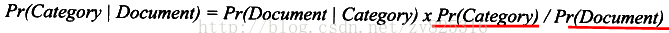

所以，为了求出Pr（Category|Document），我们必须要算出Pr（Category）和Pr（Document）。  

对于Pr（Category）的理解：就是随机选择一篇文档属于该分类的概率，就是某分类的概率嘛，我们就用属于该分类的文档总数除以文档的总数。  

而Pr（Document），书中没有解释啊的含义，我其实不理解这个到底求什么概率，不像书中将Pr（Category）描述的那么清楚，只是说可以计算，但是不必要计算，因为我们会比较该文档属于各个分类的概率，然后对这几个概率进行比较，又由于不同的这几个概率如果都除以Pr（Document）的话，那么对比较这几个概率完全没有意义。所以就不要计算了。但是我还有点想知道，这到底是计算什么。计算这个文档的概率？希望高人解答。


所以我们现在就要写一个方法，用来计算Pr（Document|Category）和Pr（Category）相乘。
代码如下，加入到naivebayes类里：

In [22]:
def prob(self,item,cat):
    catprob = self.catcount(cat)/self.totalcount()
    docprob = self.docprob(item,cat)
    return docprob * catprob

In [23]:
c1=naivebayes(getwords)
sampletrain(c1)
c1.prob('quick rabbit','good')

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


0.15624999999999997

In [24]:
c1.prob('quick rabbit','bad')

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


0.05

到此为止，我们在上列中，将文档quick rabbit（虽然这个文档很短，但千万不要在这里把它视作为单词）传给了我们的朴素贝叶斯分类器，它告诉了我们，这个文档属于goodde概率为0.156250，属于bad的概率是0.050000。
文档更适合于“good”分类

工程角度的完善  

但是从工程的角度来考虑，特别是对一个垃圾邮寄过滤的系统，这并不意味着我们就可以把所有判断为bad类的文档作为垃圾邮件处理，这是有可能因为这样阻拦就让一封重要的邮件被作为垃圾邮件处理了，这不是我们愿意看到的事情。因为可能因为这么一件小事，却让用户完全失去了对过滤系统的信任：虽然垃圾邮件过滤系统能过滤掉垃圾，但是有可能过滤掉重要的邮件。
所以我们不会轻松将一份邮件作为垃圾邮件处理，更科学的做法是，我们会比较某文档属于某分类的最大概率和次大概率进行比较，本例子中，就是将good的概率和bad的概率进行比较，如果bad的概率大于good的概率的三倍。那么我们认为极有可能是垃圾邮件，甚至更人性化的垃圾邮件过滤系统会请人自己设置这个“阈值”，超过这个阈值，就被判断为某个分类，我们也允许垃圾邮件过滤系统直接告诉客户：我分不清这个邮件。这样避免了一些危机的发生：错将一封重要邮件当作。所以，没有大于三倍（也可以是个阈值），我们决定直接告诉用户：不知道分类。
我们为naivebayes定义了一个新的变量，作为阈值。  
实现代码如下：

In [25]:
def __init__(self,getfeatures):
    classifier.__init__(self,getfeatures)
    #阈值,最大概率大过次大概率多少倍，就可以判定为最大概率的分类 
    self.thresholds={}
    
#设置阈值是多少  
def setthreshold(self,cat,t):
    self.thresholds[cat] = t
    
 #查看阈值是多少
def getthreshold(self,cat):
    #默认值1.0
    if cat not in self.thresholds: return 1.0
    return self.thresholds[cat]

阈值到底怎么用？看完下面的代码你就明白了。

In [26]:
#item就是我们传入的文档 
def classify(self,item,default = None):
    probs = {}
    #寻找概率最大的分类
    max=0.0
    for cat in self.categories():
        probs[cat] = self.prob(item,cat)
        if probs[cat]>max:
            max = probs[cat]
            best = cat#best代表最大概率值  
    #确保概率值超过阈值*次大概率值 
    for cat in probs:
        if cat == best: continue
        if probs[cat]*self.getthreshold(best) > probs[best]: return default
    return best
            

In [27]:
import sys   
sys.setrecursionlimit(1000000) 
c1 = naivebayes(getwords)
sampletrain(c1)
c1.classify('quick rabbit',default = 'unknown')

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


'good'

In [28]:
c1.classify('quick money',default = 'unknown')

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


'bad'

In [29]:
c1.setthreshold('bad',3.0)
c1.classify('quick money',default = 'unknown')

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


'unknown'

In [30]:
for i in range(10): sampletrain(c1)
c1.classify('quick money',default = 'unknown')

D:\anaconda\envs\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: split() requires a non-empty pattern match.
  # Remove the CWD from sys.path while we load stuff.


'bad'

如此一来，就不会轻易把一个文档判断为bad，必须要大于阈值才能肯定为bad。